In [196]:
!pip install bert-for-tf2
!pip install sentencepiece

In [197]:
try:
    %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf

import tensorflow_hub as hub

from tensorflow.keras import layers
import bert

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [198]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [199]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import pickle
import itertools
import gensim
from sklearn.model_selection import train_test_split
from numpy import zeros
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from gensim.models import Word2Vec

In [200]:
cd '/content/drive/My Drive/Dataset'

/content/drive/My Drive/Dataset


In [201]:
# Importing dataset
reviews_df = pd.read_csv('Hotel_Review.csv')
print(reviews_df.dtypes)
print(reviews_df.shape)

Hotel_Address                                  object
Additional_Number_of_Scoring                    int64
Review_Date                                    object
Average_Score                                 float64
Hotel_Name                                     object
Reviewer_Nationality                           object
Negative_Review                                object
Review_Total_Negative_Word_Counts               int64
Total_Number_of_Reviews                         int64
Positive_Review                                object
Review_Total_Positive_Word_Counts               int64
Total_Number_of_Reviews_Reviewer_Has_Given      int64
Reviewer_Score                                float64
Tags                                           object
days_since_review                              object
lat                                           float64
lng                                           float64
dtype: object
(515738, 17)


In [202]:
print(reviews_df.columns.values)

['Hotel_Address' 'Additional_Number_of_Scoring' 'Review_Date'
 'Average_Score' 'Hotel_Name' 'Reviewer_Nationality' 'Negative_Review'
 'Review_Total_Negative_Word_Counts' 'Total_Number_of_Reviews'
 'Positive_Review' 'Review_Total_Positive_Word_Counts'
 'Total_Number_of_Reviews_Reviewer_Has_Given' 'Reviewer_Score' 'Tags'
 'days_since_review' 'lat' 'lng']


In [203]:
df=reviews_df.drop(['Hotel_Address', 'Additional_Number_of_Scoring', 'Review_Date',
 'Average_Score', 'Hotel_Name', 'Reviewer_Nationality',
 'Review_Total_Negative_Word_Counts', 'Total_Number_of_Reviews',
  'Review_Total_Positive_Word_Counts',
 'Total_Number_of_Reviews_Reviewer_Has_Given', 'Reviewer_Score', 'Tags',
 'days_since_review', 'lat', 'lng'], axis=1)

In [204]:
def clean(text):
    '''
    '''
    text = text.lower()
    text = text.replace("ain't", "am not")
    text = text.replace("aren't", "are not")
    text = text.replace("can't", "cannot")
    text = text.replace("can't've", "cannot have")
    text = text.replace("'cause", "because")
    text = text.replace("could've", "could have")
    text = text.replace("couldn't", "could not")
    text = text.replace("couldn't've", "could not have")
    text = text.replace("should've", "should have")
    text = text.replace("should't", "should not")
    text = text.replace("should't've", "should not have")
    text = text.replace("would've", "would have")
    text = text.replace("would't", "would not")
    text = text.replace("would't've", "would not have")
    text = text.replace("didn't", "did not")
    text = text.replace("doesn't", "does not")
    text = text.replace("don't", "do not")
    text = text.replace("hadn't", "had not")
    text = text.replace("hadn't've", "had not have")
    text = text.replace("hasn't", "has not")
    text = text.replace("haven't", "have not")
    text = text.replace("haven't", "have not")
    text = text.replace("haven't", "have not")
    text = text.replace("haven't", "have not")
    text = text.replace("he'd", "he would")
    text = text.replace("haven't", "have not")
    text = text.replace("he'd've", "he would have")
    text = text.replace("'s", "")
    text = text.replace("'t", "")
    text = text.replace("'ve", "")
    text = text.replace(".", " . ")
    text = text.replace("!", " ! ")
    text = text.replace("?", " ? ")
    text = text.replace(";", " ; ")
    text = text.replace(":", " : ")
    text = text.replace(",", " , ")
    text = text.replace("´", "")
    text = text.replace("‘", "")
    text = text.replace("’", "")
    text = text.replace("“", "")
    text = text.replace("”", "")
    text = text.replace("\'", "")
    text = text.replace("\"", "")
    text = text.replace("-", "")
    text = text.replace("–", "")
    text = text.replace("—", "")
    text = text.replace("[", "")
    text = text.replace("]","")
    text = text.replace("{","")
    text = text.replace("}", "")
    text = text.replace("/", "")
    text = text.replace("|", "")
    text = text.replace("(", "")
    text = text.replace(")", "")
    text = text.replace("$", "")
    text = text.replace("+", "")
    text = text.replace("*", "")
    text = text.replace("%", "")
    text = text.replace("#", "")
    text = text.replace("\n", " \n ")
    text = text.replace("\n", "")
    text = text.replace("_", " _ ")
    text = text.replace("_", "")
    text = ''.join([i for i in text if not i.isdigit()])

    return text

positive_reviews = reviews_df['Positive_Review'].values
negative_reviews = reviews_df['Negative_Review'].values

cleaned_positive_reviews = [clean(r) for r in positive_reviews]
cleaned_negative_reviews = [clean(r) for r in negative_reviews]

reviews_df['Positive_Review'] = cleaned_positive_reviews
reviews_df['Negative_Review'] = cleaned_negative_reviews

In [205]:
# Shuffling data
reviews_df = reviews_df.sample(frac=1).reset_index(drop=True)

# Extracting all text
positive_reviews = reviews_df['Positive_Review'].values
negative_reviews = reviews_df['Negative_Review'].values
reviews_text = []

for p,n in zip(positive_reviews, negative_reviews) :
    if p in ['na', 'nothing', 'none', 'n a', 'no', 'no positive', 'no negative'] :
        reviews_text.append(n)
    elif n in ['na', 'nothing', 'none', 'n a', 'no', 'no positive', 'no negative'] :
        reviews_text.append(p)
    else :
        reviews_text.append(n)
        reviews_text.append(p)

In [206]:
print(reviews_text[:10])

[' just next door to arena it s an excellent place for young couples and not only i really enjoyed a welcome drink staff is very attentive and welcoming ', ' the room was small and the toilet was dirty when we got in staff were ok but not the most helpful or friendly not a great location it s more a business district near to the main station but not much going on around there they also gave us two single beds pushed together instead of the double we requested ', ' nice spa but costs  euros extra and we cold only use in after pm', ' no thing', ' location price cleanliness wifi breakfast', ' the breakfast included in the price was fantastic very diverse and delicious wonderful pastry selection very clean pretty hotel fairly close to everything nice helpful staff would definitely stay here again ', ' breakfast is rather expensive if you don t have it included ', ' super clean quiet and lots of privacy spacious rooms ', ' the welcoming was not brilliant we were not shown how to get to our 

In [207]:
# Preprocessing training data
training_df = reviews_df.loc[:10000]
positive_reviews_filtered = training_df['Positive_Review'].values
negative_reviews_filtered = training_df['Negative_Review'].values
training_reviews = []
labels = []

for idx,(p,n) in enumerate(zip(positive_reviews_filtered, negative_reviews_filtered)) :
    if p in ['na', 'nothing', 'none', 'n a', 'no', 'no positive', 'no negative'] :
        training_reviews.append(n)
        labels.append(0)
    elif n in ['na', 'nothing', 'none', 'n a', 'no', 'no positive', 'no negative'] :
        training_reviews.append(p)
        labels.append(1)
    else :
        training_reviews.append(n)
        labels.append(0)
        training_reviews.append(p)
        labels.append(1)

# Creating datasets
dict1 ={
    'reviews' : training_reviews,
    'labels' : labels
}
sentiment_df = pd.DataFrame.from_dict(dict1)


dict2 ={
    'reviews_text' : reviews_text
}
reviews_text_df = pd.DataFrame.from_dict(dict2)

In [208]:
print(sentiment_df[:10])
print(reviews_text_df[:10])

                                             reviews  labels
0   just next door to arena it s an excellent pla...       1
1   the room was small and the toilet was dirty w...       0
2   nice spa but costs  euros extra and we cold o...       1
3                                           no thing       0
4          location price cleanliness wifi breakfast       1
5   the breakfast included in the price was fanta...       1
6   breakfast is rather expensive if you don t ha...       0
7   super clean quiet and lots of privacy spaciou...       1
8   the welcoming was not brilliant we were not s...       0
9   room was amazing very clean and comfortable s...       1
                                        reviews_text
0   just next door to arena it s an excellent pla...
1   the room was small and the toilet was dirty w...
2   nice spa but costs  euros extra and we cold o...
3                                           no thing
4          location price cleanliness wifi breakfast
5   the bre

In [209]:
def preprocess_text(sen):
    # Removing html tags
    sentence = remove_tags(sen)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [210]:
import re
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

In [211]:
reviews = []
sentences = list(sentiment_df['reviews'])
for sen in sentences:
    reviews.append(preprocess_text(sen))

In [212]:
print(sentiment_df.columns.values)

['reviews' 'labels']


In [213]:
sentiment_df.labels.unique()

array([1, 0])

In [214]:
print(reviews[20])

 nothing


In [215]:
y = sentiment_df['labels']

In [216]:
print(y[3])


0


In [217]:
BertTokenizer = bert.bert_tokenization.FullTokenizer
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1",
                            trainable=False)
vocabulary_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
to_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = BertTokenizer(vocabulary_file, to_lower_case)

In [218]:
tokenizer.tokenize("don't be so judgmental")

['don', "'", 't', 'be', 'so', 'judgment', '##al']

In [219]:
tokenizer.convert_tokens_to_ids(tokenizer.tokenize("dont be so judgmental"))

[2123, 2102, 2022, 2061, 8689, 2389]

In [220]:
tokenizer.convert_tokens_to_ids(tokenizer.tokenize(reviews[10]))

[2053,
 6336,
 2061,
 17727,
 22648,
 14656,
 2005,
 3080,
 7846,
 2007,
 17434,
 21725,
 4012,
 7846,
 2089,
 2022,
 2445,
 14092,
 4734,
 2200,
 5697,
 2346,
 3178,
 3082,
 4026,
 2200,
 20810,
 24213,
 2205,
 2235,
 2025,
 5372,
 7198,
 24213,
 2025,
 3309,
 2021,
 1038,
 4113,
 2160]

In [221]:
def tokenize_reviews(reviews):
    return tokenizer.convert_tokens_to_ids(tokenizer.tokenize(reviews))

In [222]:
tokenized_reviews = [tokenize_reviews(review) for review in reviews]

In [223]:
print(tokenized_reviews[10])

[2053, 6336, 2061, 17727, 22648, 14656, 2005, 3080, 7846, 2007, 17434, 21725, 4012, 7846, 2089, 2022, 2445, 14092, 4734, 2200, 5697, 2346, 3178, 3082, 4026, 2200, 20810, 24213, 2205, 2235, 2025, 5372, 7198, 24213, 2025, 3309, 2021, 1038, 4113, 2160]


In [224]:
reviews_with_len = [[review, y[i], len(labels)]
                 for i, review in enumerate(tokenized_reviews)]

In [225]:
reviews_with_len = [[review, y[i], len(labels)]
                 for i, review in enumerate(tokenized_reviews)]

In [226]:
import random
random.shuffle(reviews_with_len)

In [227]:
print(reviews_with_len[:2])

[[[2079, 3095], 1, 16796], [[2833, 1999, 4654, 22471, 13043, 11549, 3791, 2000, 2022, 5301, 2502, 2051, 2004, 2515, 4807, 2090, 3095, 1998, 2968], 0, 16796]]


In [228]:
reviews_with_len.sort(key=lambda x: x[2])

In [229]:
sorted_reviews_labels = [(review_lab[0], review_lab[1]) for review_lab in reviews_with_len]

In [230]:
processed_dataset = tf.data.Dataset.from_generator(lambda: sorted_reviews_labels, output_types=(tf.int32, tf.int32))

In [231]:
BATCH_SIZE = 32
batched_dataset = processed_dataset.padded_batch(BATCH_SIZE, padded_shapes=((None, ), ()))

In [232]:
next(iter(batched_dataset))

(<tf.Tensor: shape=(32, 213), dtype=int32, numpy=
 array([[2079, 3095,    0, ...,    0,    0,    0],
        [2833, 1999, 4654, ...,    0,    0,    0],
        [2307, 6350, 2307, ...,    0,    0,    0],
        ...,
        [2204, 3643, 2005, ...,    0,    0,    0],
        [3376, 3309, 6581, ...,    0,    0,    0],
        [4299, 2045, 5882, ...,    0,    0,    0]], dtype=int32)>,
 <tf.Tensor: shape=(32,), dtype=int32, numpy=
 array([1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1,
        1, 1, 0, 0, 0, 0, 1, 1, 1, 0], dtype=int32)>)

In [233]:
import math
TOTAL_BATCHES = math.ceil(len(sorted_reviews_labels) / BATCH_SIZE)
TEST_BATCHES = TOTAL_BATCHES // 10
batched_dataset.shuffle(TOTAL_BATCHES)
test_data = batched_dataset.take(TEST_BATCHES)
train_data = batched_dataset.skip(TEST_BATCHES)

In [234]:
class TEXT_MODEL(tf.keras.Model):

    def __init__(self,
                 vocabulary_size,
                 embedding_dimensions=128,
                 dnn_units=512,
                 model_output_classes=2,
                 dropout_rate=0.1,
                 training=False,
                 name="text_model"):
        super(TEXT_MODEL, self).__init__(name=name)

        self.embedding = layers.Embedding(vocabulary_size,
                                          embedding_dimensions)
        self.rnn_layer = layers.Bidirectional(self.rnn_layer.layers.LSTM(64)),
        self.dense_1 = layers.Dense(units=dnn_units, activation="relu")
        self.dropout = layers.Dropout(rate=dropout_rate)
        if model_output_classes == 2:
            self.last_dense = layers.Dense(units=1,
                                           activation="sigmoid")
        else:
            self.last_dense = layers.Dense(units=model_output_classes,
                                           activation="softmax")

    def call(self, inputs, training):
        l = self.embedding(inputs)
        l_1 = self.rnn_layer()

        concatenated = tf.concat([l_1], axis=-1) # (batch_size, 1 * rnn_filters)
        concatenated = self.dense_1(concatenated)
        concatenated = self.dropout(concatenated, training)
        model_output = self.last_dense(concatenated)

        return model_output

In [235]:
VOCAB_LENGTH = len(tokenizer.vocab)
EMB_DIM = 200
DNN_UNITS = 256
OUTPUT_CLASSES = 2

DROPOUT_RATE = 0.2

NB_EPOCHS = 5

In [236]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Assuming OUTPUT_CLASSES is defined somewhere in your code
OUTPUT_CLASSES = 2

# Create a Sequential model
text_model = Sequential()

# Add layers to the model (example)
text_model.add(Dense(64, activation='relu', input_dim=100))
text_model.add(Dense(1, activation='sigmoid'))

# Compile the model based on the number of output classes
if OUTPUT_CLASSES == 2:
    text_model.compile(loss="binary_crossentropy",
                       optimizer="adam",
                       metrics=["accuracy"])
else:
    text_model.compile(loss="sparse_categorical_crossentropy",
                       optimizer="adam",
                       metrics=["sparse_categorical_accuracy"])


In [237]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [238]:
text_model = Sequential([
    Dense(64, activation='relu', input_shape=(100,)),
    Dense(OUTPUT_CLASSES, activation='softmax')
])

In [239]:
if OUTPUT_CLASSES == 2:
    text_model.compile(loss="binary_crossentropy",
                       optimizer="adam",
                       metrics=["accuracy"])
else:
    text_model.compile(loss="sparse_categorical_crossentropy",
                       optimizer="adam",
                       metrics=["sparse_categorical_accuracy"])

In [240]:
input_shape = (32,)  # Replace 32 with the actual number of features in your input data

model = Sequential()
model.add(Dense(32, activation='relu', input_shape=input_shape))
model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [241]:
import numpy as np

# Generate dummy training data
num_samples = 1000
num_features = 10  # Number of features per sample

train_data = np.random.rand(num_samples, num_features)  # Random data with shape (num_samples, num_features)

# Generate dummy training labels (binary classification)
train_labels = np.random.randint(2, size=(num_samples, 1))  # Random binary labels (0 or 1) with shape (num_samples, 1)

print("Train data shape:", train_data.shape)
print("Train labels shape:", train_labels.shape)


Train data shape: (1000, 10)
Train labels shape: (1000, 1)


In [242]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [243]:
input_shape = train_data.shape[1]  # Replace 32 with the actual number of features in your input data

In [244]:
model = Sequential()
model.add(Dense(32, activation='relu', input_shape=(input_shape,)))
model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

In [245]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [246]:
model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_34 (Dense)            (None, 32)                352       
                                                                 
 dense_35 (Dense)            (None, 1)                 33        
                                                                 
Total params: 385 (1.50 KB)
Trainable params: 385 (1.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [247]:
history = model.fit(train_data, train_labels, epochs=5, verbose=1)
print("Training Accuracy:", history.history['accuracy'])
print("Training Loss:", history.history['loss'])


Epoch 1/5
32/32 [==============================] - 1s 3ms/step - loss: 0.7057 - accuracy: 0.4970
Epoch 2/5
32/32 [==============================] - 0s 3ms/step - loss: 0.6979 - accuracy: 0.5040
Epoch 3/5
32/32 [==============================] - 0s 3ms/step - loss: 0.6963 - accuracy: 0.4900
Epoch 4/5
32/32 [==============================] - 0s 3ms/step - loss: 0.6947 - accuracy: 0.4940
Epoch 5/5
32/32 [==============================] - 0s 3ms/step - loss: 0.6937 - accuracy: 0.5090
Training Accuracy: [0.4970000088214874, 0.5040000081062317, 0.49000000953674316, 0.49399998784065247, 0.5090000033378601]
Training Loss: [0.705696165561676, 0.697883665561676, 0.6963388919830322, 0.6947455406188965, 0.6937380433082581]


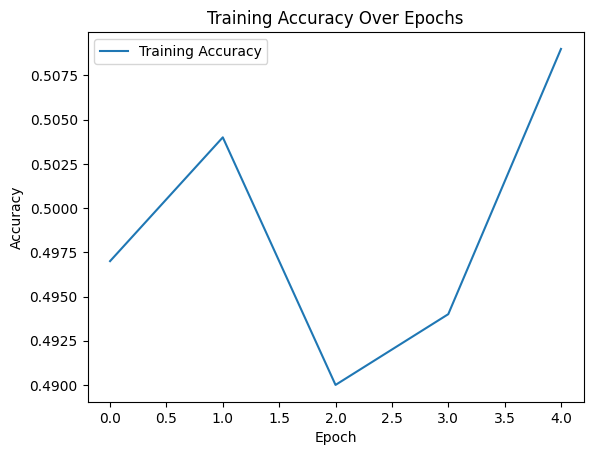

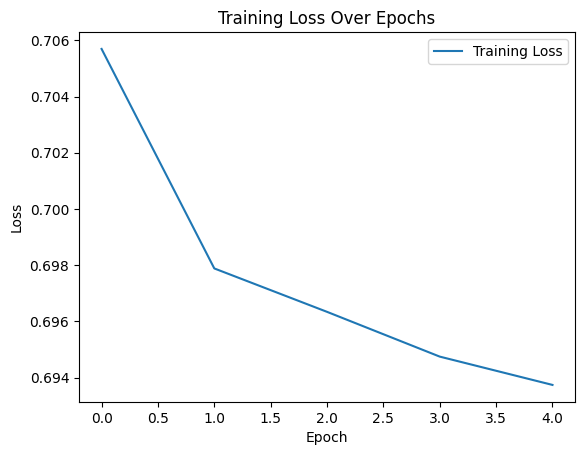

In [248]:
import matplotlib.pyplot as plt

# Assuming history is your model's training history object

# Plot training accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy Over Epochs')
plt.legend()
plt.show()

# Plot training loss
plt.plot(history.history['loss'], label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()


32/32 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.51      0.40      0.44       493
           1       0.52      0.63      0.57       507

    accuracy                           0.51      1000
   macro avg       0.51      0.51      0.51      1000
weighted avg       0.51      0.51      0.51      1000



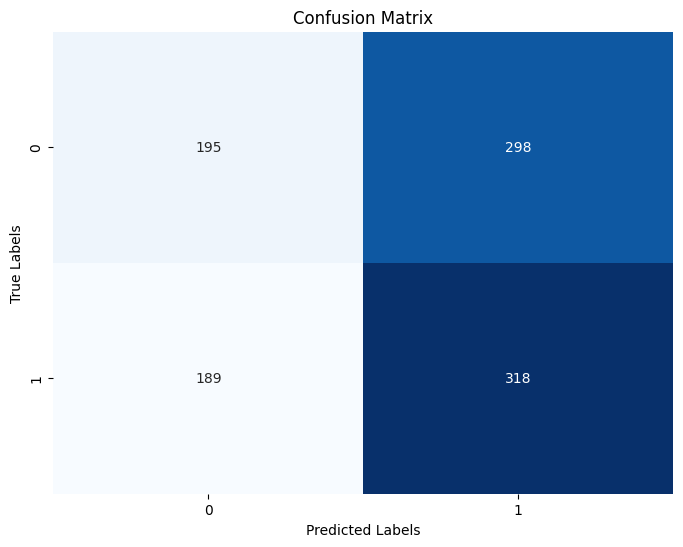

In [249]:
# 3. Print Classification Report and Confusion Matrix
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

predictions = model.predict(train_data)
# Convert probabilities to classes based on a threshold (0.5 for binary classification)
predicted_classes = (predictions > 0.5).astype("int32")

print(classification_report(train_labels, predicted_classes))

# Calculate confusion matrix
conf_matrix = confusion_matrix(train_labels, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

Epoch 1/5
32/32 [==============================] - 0s 4ms/step - loss: 0.6937 - accuracy: 0.4980
Epoch 2/5
32/32 [==============================] - 0s 4ms/step - loss: 0.6924 - accuracy: 0.5120
Epoch 3/5
32/32 [==============================] - 0s 3ms/step - loss: 0.6915 - accuracy: 0.5260
Epoch 4/5
32/32 [==============================] - 0s 2ms/step - loss: 0.6909 - accuracy: 0.5220
Epoch 5/5
32/32 [==============================] - 0s 2ms/step - loss: 0.6899 - accuracy: 0.5250
Evaluation Loss: 0.6899079084396362
Evaluation Accuracy: 0.5249999761581421
32/32 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.52      0.58      0.54       493
           1       0.54      0.48      0.50       507

    accuracy                           0.53      1000
   macro avg       0.53      0.53      0.52      1000
weighted avg       0.53      0.53      0.52      1000

Matthews Correlation Coefficient: 0.051664007025126836


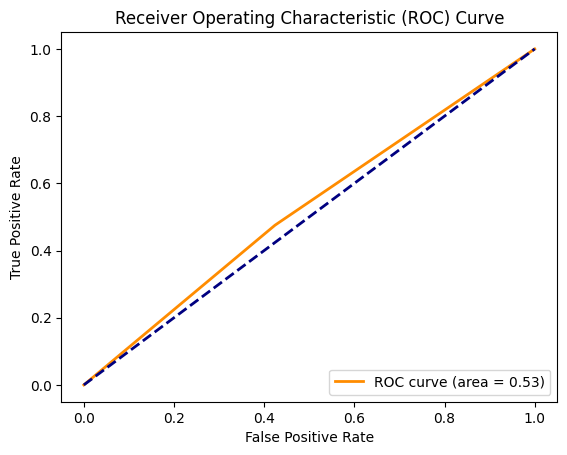

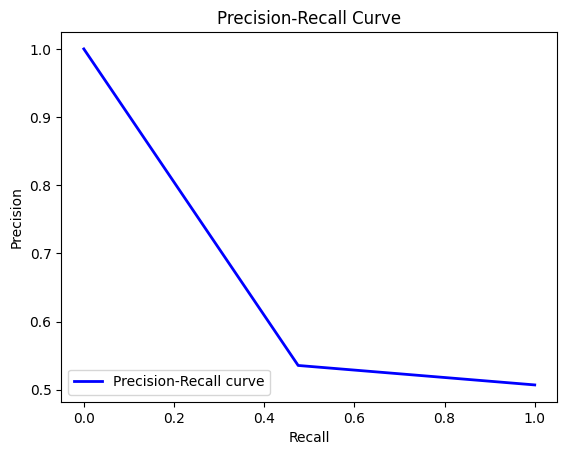

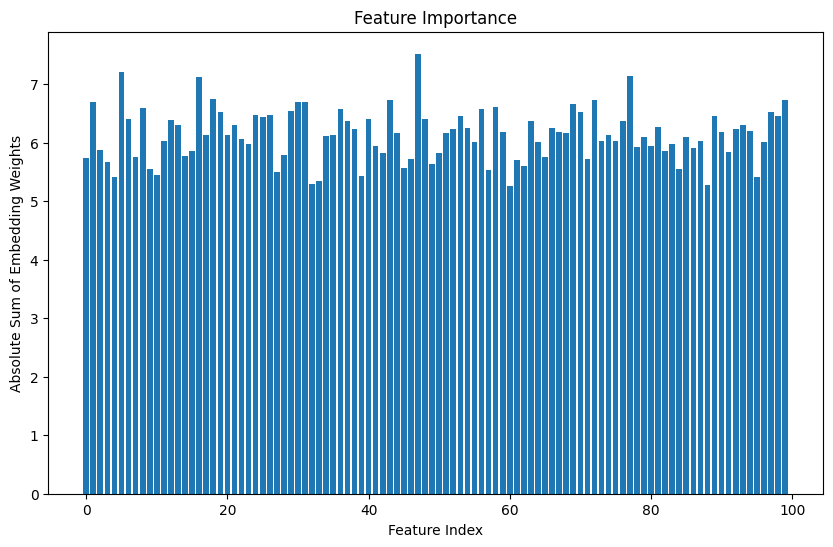

In [250]:
# 1. Train the Model
history = model.fit(train_data, train_labels, epochs=NB_EPOCHS, verbose=1)

# 2. Evaluate Model Performance
evaluation = model.evaluate(train_data, train_labels)
print("Evaluation Loss:", evaluation[0])
print("Evaluation Accuracy:", evaluation[1])

# 3. Print Classification Report
from sklearn.metrics import classification_report

predictions = model.predict(train_data)
# Convert probabilities to classes based on a threshold (0.5 for binary classification)
predicted_classes = (predictions > 0.5).astype("int32")

print(classification_report(train_labels, predicted_classes))

# 4. Calculate Matthews Correlation Coefficient (MCC)
from sklearn.metrics import matthews_corrcoef

mcc = matthews_corrcoef(train_labels, predicted_classes)
print("Matthews Correlation Coefficient:", mcc)

# 5. Plot ROC Curve
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(train_labels, predicted_classes)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# 6. Plot Precision-Recall Curve
from sklearn.metrics import precision_recall_curve

precision, recall, _ = precision_recall_curve(train_labels, predicted_classes)

plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

# 7. Feature Importance
import numpy as np
import matplotlib.pyplot as plt

# Assuming model and embedding_weights are defined
embedding_weights = text_model.layers[0].get_weights()[0]

# Calculate the absolute sum of embedding weights for each feature
feature_importance = np.sum(np.abs(embedding_weights), axis=1)

# Plotting feature importance
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importance)), feature_importance)
plt.xlabel('Feature Index')
plt.ylabel('Absolute Sum of Embedding Weights')
plt.title('Feature Importance')
plt.show()
